In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import SnowballStemmer
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import sparse
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

In [2]:
airbnb = pd.read_csv('listings.csv')

In [3]:
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.36575,4.94142,Private room,59,3,278,2020-02-14,2.00,1,125
1,20168,Studio with private bathroom in the centre 1,59484,Alexander,NaN,Centrum-Oost,52.36509,4.89354,Private room,209,1,340,2020-04-09,2.67,3,3
2,25428,Lovely apt in City Centre (w.lift) near Jordaan,56142,Joan,NaN,Centrum-West,52.37297,4.88339,Entire home/apt,125,14,5,2020-02-09,0.16,1,188
3,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,NaN,Centrum-West,52.38761,4.89188,Private room,135,2,219,2020-07-25,2.09,1,183
4,28871,Comfortable double room,124245,Edwin,NaN,Centrum-West,52.36719,4.89092,Private room,75,2,334,2020-08-16,2.74,2,348


In [4]:
amsterdam_heatmap = folium.Map([52.3727, 4.8931], title='Amsterdam')
HeatMap(airbnb[['latitude', 'longitude']],min_opacity=0.01,max_val=0.8,blur=30).add_to(amsterdam_heatmap)
amsterdam_heatmap

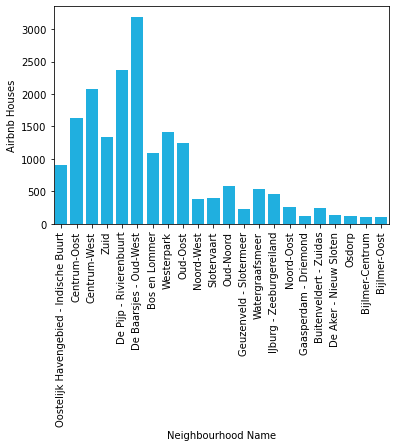

In [5]:
sns.countplot(airbnb.neighbourhood, color='deepskyblue')
plt.xticks(rotation=90)
plt.xlabel('Neighbourhood Name')
plt.ylabel('Airbnb Houses');

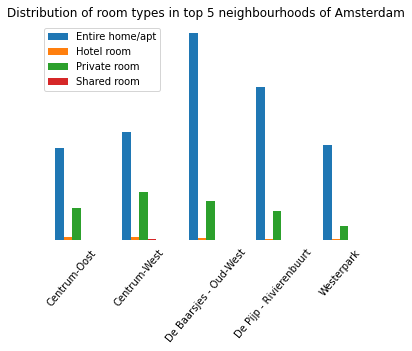

In [6]:
#top 5 neighbourhoods
top5_neighbourhoods = airbnb.neighbourhood.value_counts().sort_values(ascending=False)[:5]
top5_neighbourhoods = airbnb[airbnb.neighbourhood.isin(top5_neighbourhoods.index)][['neighbourhood', 'room_type','price']]
top5_neighbourhoods = top5_neighbourhoods.groupby(['neighbourhood','room_type']).count()
top5_neighbourhoods = top5_neighbourhoods.unstack()
top5_neighbourhoods.columns = top5_neighbourhoods.columns.droplevel(0)
top5_neighbourhoods.plot(kind='bar')
plt.legend(title='')
plt.xticks(rotation=50)
plt.xlabel('')
plt.box(on=False)
plt.yticks(ticks=[])
plt.gca().xaxis.set_ticks_position('none')
plt.title('Distribution of room types in top 5 neighbourhoods of Amsterdam', loc='center');

The top 5 neighbourhoods are mostly comprised of entire homes being rented out.
Private rooms are a distant second.

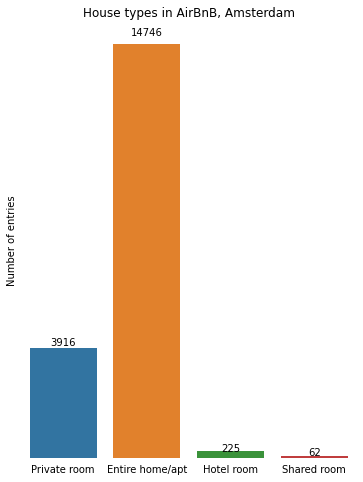

In [7]:
plt.figure(figsize=(6,8))
room = sns.countplot(airbnb.room_type)
for i in room.get_children()[:4]:
    height = i.get_height()
    plt.text(i.get_x()+(i.get_width())/2,height*1.02, str(height), ha='center')
plt.box(False)
plt.yticks(ticks=[])
plt.ylabel('Number of entries')
plt.xlabel('')
plt.gca().xaxis.set_ticks_position('none')
plt.title('House types in AirBnB, Amsterdam');

Most AirBnB partners are people that give up entire homes/apartments for rent

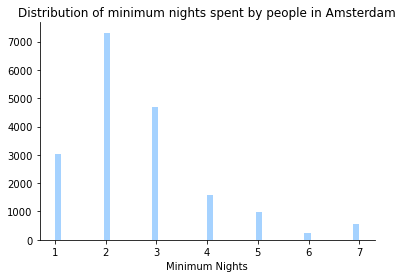

In [8]:
sns.distplot(airbnb[airbnb.minimum_nights <= airbnb.minimum_nights.quantile(0.95)]['minimum_nights'], kde=False, color='dodgerblue')
plt.xticks(ticks=np.arange(1.00,airbnb.minimum_nights.quantile(0.95)+1), labels=range(1,int(airbnb.minimum_nights.quantile(0.95))+2))
plt.xlabel('Minimum Nights')
plt.title('Distribution of minimum nights spent by people in Amsterdam');
l = plt.gca()
l.spines['right'].set_visible(False)
l.spines['top'].set_visible(False)

95% people spend 7 nights in Amsterdam

In [9]:
#90th to 99th quantile of prices of airbnb locations
print(airbnb.price.quantile(np.arange(0.9,1.0,0.01)))

0.90    252.00
0.91    271.00
0.92    282.00
0.93    299.00
0.94    300.00
0.95    334.60
0.96    350.00
0.97    400.00
0.98    456.04
0.99    595.00
Name: price, dtype: float64


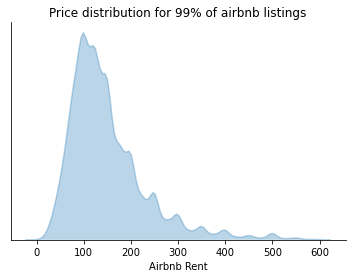

In [10]:
sns.kdeplot(airbnb[airbnb.price <= 595]['price'], shade=True, alpha=0.3,legend=False)
plt.xlabel('Airbnb Rent')
plt.ylabel('')
plt.title('Price distribution for 99% of airbnb listings')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yticks([]);

Most houses are around $100

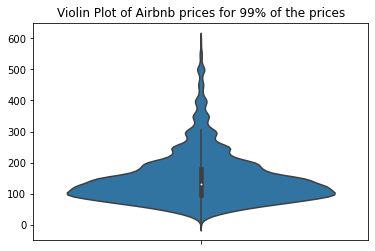

In [11]:
sns.violinplot(airbnb[airbnb.price <= 595]['price'], orient='v')
plt.ylabel('')
plt.title('Violin Plot of Airbnb prices for 99% of the prices');

The violin plot captures 99% of the data points

In [12]:
cleaned = airbnb[airbnb.price<=595]

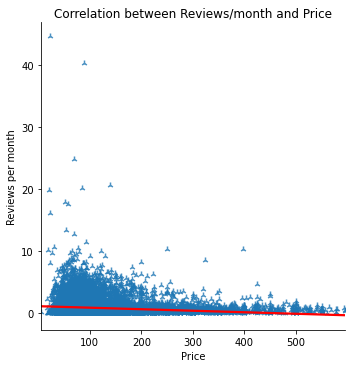

In [13]:
sns.lmplot(x='price', y='reviews_per_month', data=cleaned, markers='2',line_kws={'color': 'red'})
plt.xlabel('Price')
plt.ylabel('Reviews per month')
plt.title('Correlation between Reviews/month and Price');

The red line shows that the price slightly decreases as number of reviews per month increases. The correlation however is too small to consider useful.

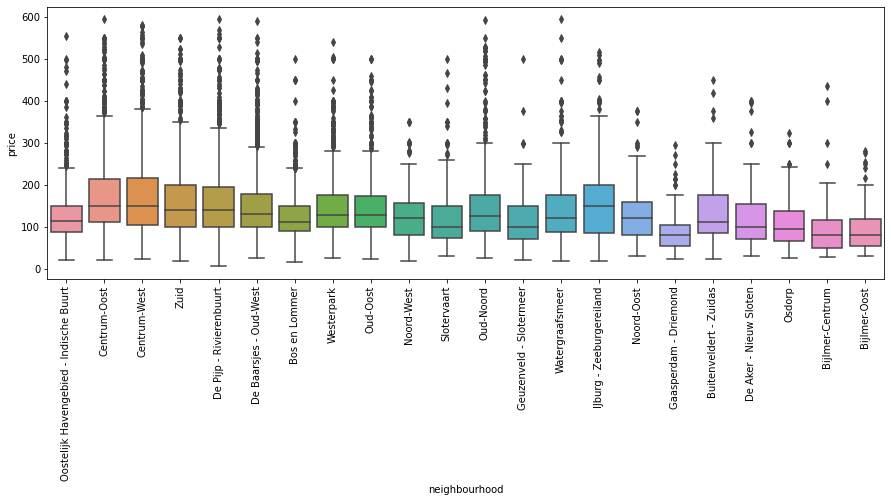

In [14]:
plt.figure(figsize=(15,5))
sns.boxplot(x='neighbourhood',y='price',data=cleaned)
plt.xticks(rotation=90);

The box plot shows that the median price of the airbnb hotel/houses varies according to the neighbourhood as well

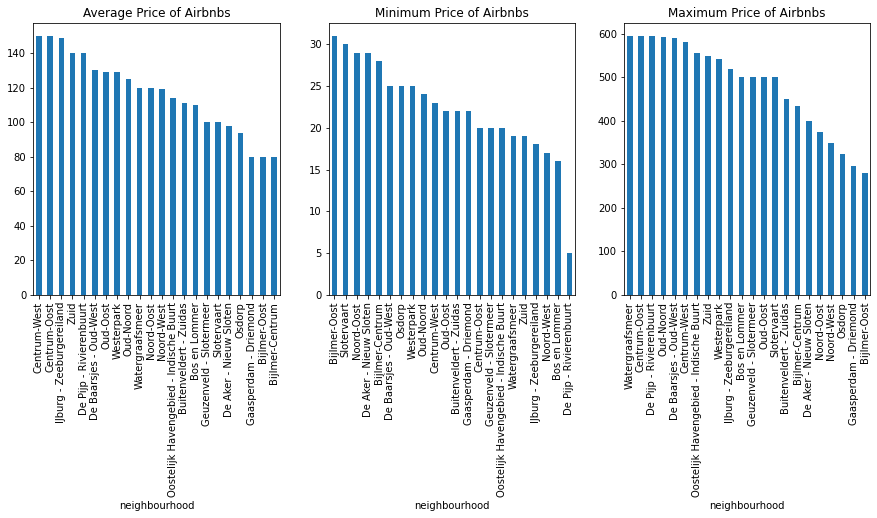

In [15]:
neighbourhoods = cleaned.groupby('neighbourhood')['price']

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
neighbourhoods.median().sort_values(ascending=False).plot(kind='bar')
plt.title('Average Price of Airbnbs')

plt.subplot(1,3,2)
neighbourhoods.min().sort_values(ascending=False).plot(kind='bar')
plt.title('Minimum Price of Airbnbs')

plt.subplot(1,3,3)
neighbourhoods.max().sort_values(ascending=False).plot(kind='bar')
plt.title('Maximum Price of Airbnbs');


In [16]:
cleaned.minimum_nights.quantile(np.arange(0.90,1.01,0.01))

0.90       5.0
0.91       5.0
0.92       5.0
0.93       6.0
0.94       6.0
0.95       7.0
0.96       7.0
0.97       7.0
0.98      14.0
0.99      21.8
1.00    1001.0
Name: minimum_nights, dtype: float64

99th quantile is 21.8 days whereas the maximum value is 1000 which seems to be an outlier

In [17]:
cleaned = cleaned[cleaned.minimum_nights<7]

In [18]:
cleaned.shape

(17673, 16)

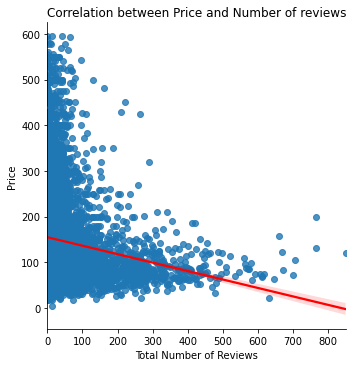

In [19]:
sns.lmplot(x = 'number_of_reviews', y='price', data=cleaned, line_kws={'color':'red'})
plt.xlabel('Total Number of Reviews')
plt.title('Correlation between Price and Number of reviews')
plt.ylabel('Price');

In [20]:
cleaned = cleaned.drop(['neighbourhood_group', 'host_id', 'host_name', 'id', 'last_review',
              'availability_365', 'calculated_host_listings_count', 'latitude', 'longitude'], axis=1)

In [21]:
cleaned.isnull().sum()

name                   31
neighbourhood           0
room_type               0
price                   0
minimum_nights          0
number_of_reviews       0
reviews_per_month    1944
dtype: int64

In [22]:
#Dropping all rows that have no name/description
cleaned = cleaned.dropna(subset=['name'])

In [23]:
cleaned[cleaned.reviews_per_month.isnull()]['number_of_reviews'].describe()

count    1936.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: number_of_reviews, dtype: float64

Number of reveiws for each null row is 0, thus we can just replace nan with 0

In [24]:
cleaned.fillna(value=0, inplace=True)

In [25]:
cleaned.isnull().sum()

name                 0
neighbourhood        0
room_type            0
price                0
minimum_nights       0
number_of_reviews    0
reviews_per_month    0
dtype: int64

In [26]:
print("% of data remaining = ", (cleaned.shape[0]/airbnb.shape[0])*100)

% of data remaining =  93.10253839252731


## Prediction of AirBnB Price in Amsterdam

In [27]:
cleaned.head()

,name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month
0,Quiet Garden View Room & Super Fast WiFi,Oostelijk Havengebied - Indische Buurt,Private room,59,3,278,2.00
1,Studio with private bathroom in the centre 1,Centrum-Oost,Private room,209,1,340,2.67
3,"Romantic, stylish B&B houseboat in canal district",Centrum-West,Private room,135,2,219,2.09
4,Comfortable double room,Centrum-West,Private room,75,2,334,2.74
5,Comfortable single room,Centrum-West,Private room,55,2,480,4.18


In [28]:
cleaned = pd.concat([cleaned, pd.get_dummies(
    cleaned.neighbourhood), pd.get_dummies(cleaned.room_type)], axis=1)

In [29]:
cleaned = cleaned.drop(['neighbourhood', 'room_type'], axis=1)

In [30]:
cleaned = cleaned.drop_duplicates()

In [31]:
cleaned.head()

,name,price,minimum_nights,number_of_reviews,reviews_per_month,Bijlmer-Centrum,Bijlmer-Oost,Bos en Lommer,Buitenveldert - Zuidas,Centrum-Oost,...,Oud-Noord,Oud-Oost,Slotervaart,Watergraafsmeer,Westerpark,Zuid,Entire home/apt,Hotel room,Private room,Shared room
0,Quiet Garden View Room & Super Fast WiFi,59,3,278,2.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Studio with private bathroom in the centre 1,209,1,340,2.67,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,"Romantic, stylish B&B houseboat in canal district",135,2,219,2.09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Comfortable double room,75,2,334,2.74,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,Comfortable single room,55,2,480,4.18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Text Pre Processing steps
1. Remove punctuations
1. remove emojis
2. remove stop words
3. all lowercase
4. snowball stemming
5. Bag of words
6. tf/idf

In [32]:
# Punctuations removed
punctuations = r'[:;#*!,.&$%+=;\-()|]'
cleaned['name'] = cleaned['name'].replace(to_replace=punctuations,value=' ', regex=True)

strip each word of the sentence as i am replacing regex with space

In [33]:
#Remove stopwords
stop = set(stopwords.words('english'))

def stopword_removal(row):
    sentence = str(row)
    sentence_list = sentence.strip().split()
    sentence_list = filter(lambda x: x not in stop, sentence_list)
    sentence_list = map(lambda x: x.strip(),sentence_list)
    snowball = SnowballStemmer('english')
    sentence_list = map(snowball.stem, sentence_list)
    sentence = " ".join(sentence_list)
    return sentence.lower()

In [34]:
cleaned['clean_name'] = cleaned['name'].apply(stopword_removal)

In [35]:
cleaned.head()

,name,price,minimum_nights,number_of_reviews,reviews_per_month,Bijlmer-Centrum,Bijlmer-Oost,Bos en Lommer,Buitenveldert - Zuidas,Centrum-Oost,...,Oud-Oost,Slotervaart,Watergraafsmeer,Westerpark,Zuid,Entire home/apt,Hotel room,Private room,Shared room,clean_name
0,Quiet Garden View Room Super Fast WiFi,59,3,278,2.00,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,quiet garden view room super fast wifi
1,Studio with private bathroom in the centre 1,209,1,340,2.67,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,studio privat bathroom centr 1
3,Romantic stylish B B houseboat in canal district,135,2,219,2.09,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,romant stylish b b houseboat canal district
4,Comfortable double room,75,2,334,2.74,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,comfort doubl room
5,Comfortable single room,55,2,480,4.18,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,comfort singl room


# Model Selection Preparation for Prediction of Prices

1. Split data into train, test and cross validation sets
2. Use CountVectorizer on clean_name column, find bag of words for the train data
3. Transform CV set to bag of words representation
4. Concatenate both with their respective dummies with district dummies, reviews_per_month etc.
5. Select models using GridSearch
6. Get best parameters and compare train and cross validation set MAEs
7. Train models again with acquired best parameters with complete train data (train + cross validate)
8. Compare Model scores

## Preparation of Train and Cross Validation sets

In [36]:
X_train, X_test, y_train, y_test = train_test_split(cleaned.iloc[:,2:],cleaned.iloc[:,1], test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train, test_size=0.2)

In [37]:
bow = CountVectorizer()

clean_name = bow.fit_transform(X_train['clean_name'])
clean_name_cv = bow.transform(X_cv['clean_name'])

X_train = sparse.hstack([clean_name,X_train.iloc[:,:-1].values])
X_cv = sparse.hstack([clean_name_cv,X_cv.iloc[:,:-1].values])

## Model Hyperparameter tuning using GridSearch

In [38]:
lin = LinearRegression(n_jobs=-1).fit(X_train, y_train)

In [39]:
parameters_xgb = {
    'max_depth': [1, 2, 3, 4],
    'n_estimators': [100, 500, 1000, 1250],
    'learning_rate': [0.1, 0.15]
}

xgb = GridSearchCV(XGBRegressor(objective='reg:squarederror'), param_grid=parameters_xgb,
                   n_jobs=-1, scoring='neg_mean_absolute_error', cv=3).fit(X_train, y_train)

In [40]:
parameters_rbf = {'gamma': [0.001, 0.01, 0.1, 1, 10],
                  'C': [0.001, 0.01, 1, 10, 100, 1000]}
svr = GridSearchCV(SVR(kernel='rbf'), param_grid=parameters_rbf, n_jobs=-1, cv=3,
                   scoring='neg_mean_absolute_error').fit(X_train, y_train)

In [41]:
parameters_huber = {'alpha': [0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
lin_huber = GridSearchCV(SGDRegressor(loss='huber'), param_grid=parameters_huber, n_jobs=-1, cv=3,
                         scoring='neg_mean_absolute_error').fit(X_train, y_train)

In [42]:
hub_train, hub_cv = -lin_huber.score(X_train, y_train), -lin_huber.score(X_cv, y_cv)
xgb_train, xgb_cv = -xgb.score(X_train, y_train), -xgb.score(X_cv, y_cv)
lin_train, lin_cv = mean_absolute_error(y_train, lin.predict(X_train)), mean_absolute_error(y_cv, lin.predict(X_cv))
svr_train, svr_cv = -svr.score(X_train, y_train), -svr.score(X_cv, y_cv)

## Compare Train and Cross validation MAEs

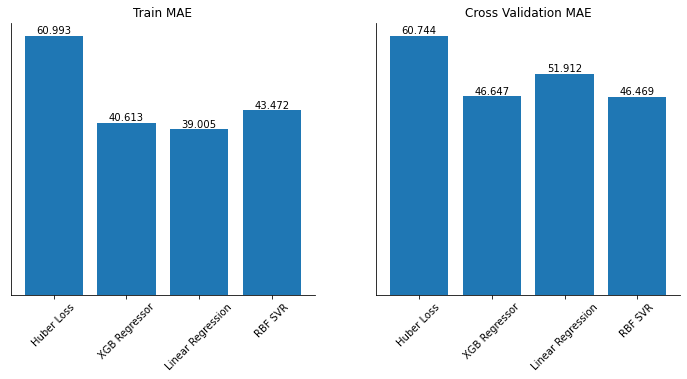

In [63]:
models = ['Huber Loss', 'XGB Regressor', 'Linear Regression', 'RBF SVR']
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
ax = plt.bar(x=models, height=np.around([hub_train, xgb_train, lin_train, svr_train], decimals=3))
plt.title('Train MAE')
for bar in ax :
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height*1.008, s=height, ha='center')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.yticks(ticks=[])

plt.subplot(1,2,2)
ax = plt.bar(x=models, height=np.around([hub_cv, xgb_cv, lin_cv, svr_cv], decimals=3))
plt.title('Cross Validation MAE')
for bar in ax :
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height*1.008, s=height, ha='center')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.yticks(ticks=[]);

None of the models seem to be overfitting the test data because CV scores and test scores are nearly equal

## Best Parameters for models

In [48]:
print("Parameters for Huber loss SGD are ", lin_huber.best_params_)
print("Parameters for XGBoost Regressor are ", xgb.best_params_)
print("Parameters for SVM Regressor are ", svr.best_params_)

Parameters for Huber loss SGD are  {'alpha': 0.0001}
Parameters for XGBoost Regressor are  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 500}
Parameters for SVM Regressor are  {'C': 1000, 'gamma': 0.001}


## Create complete train set (train + cross validating)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(cleaned.iloc[:,2:],cleaned.iloc[:,1], test_size=0.2, random_state=42)

final_cv = CountVectorizer()
clean_name = final_cv.fit_transform(X_train['clean_name'])
clean_name_test = final_cv.transform(X_test['clean_name'])

X_train = sparse.hstack([clean_name,X_train.iloc[:,:-1].values])
X_test = sparse.hstack([clean_name_test,X_test.iloc[:,:-1].values])

## Train final models with best paramters

In [49]:
final_xgb = XGBRegressor(max_depth=xgb.best_params_['max_depth'], learning_rate=xgb.best_params_[
                         'learning_rate'], n_estimators=xgb.best_params_['n_estimators'], n_jobs=-1, objective='reg:squarederror').fit(X_train, y_train)
final_lin_huber = SGDRegressor(loss='huber', alpha=lin_huber.best_params_['alpha']).fit(X_train,y_train)
final_linear_regression = LinearRegression(n_jobs=-1).fit(X_train,y_train)
final_svr = SVR(kernel='rbf', gamma=svr.best_params_['gamma'], C=svr.best_params_['C']).fit(X_train,y_train)

In [54]:
models = ['Huber Loss', 'XGB Regressor', 'Linear Regression', 'RBF SVR']

lin_train, lin_test = mean_absolute_error(y_train, final_linear_regression.predict(
    X_train)), mean_absolute_error(y_test, final_linear_regression.predict(X_test))

lin_huber_train, lin_huber_test = mean_absolute_error(y_train, final_lin_huber.predict(
    X_train)), mean_absolute_error(y_test, final_lin_huber.predict(X_test))

xgb_final_train, xgb_final_test = mean_absolute_error(y_train, final_xgb.predict(
    X_train)), mean_absolute_error(y_test, final_xgb.predict(X_test))

svr_final_train, svr_final_test = mean_absolute_error(y_train, final_svr.predict(
    X_train)), mean_absolute_error(y_test, final_svr.predict(X_test))

## Compare Test and Train MAEs for the models

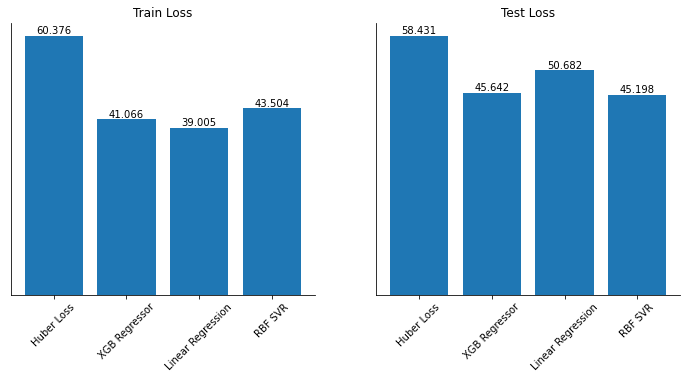

In [62]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ax = plt.bar(x=models, height=np.around(
    [lin_huber_train, xgb_final_train, lin_train, svr_final_train], decimals=3))
plt.title('Train MAE')
for bar in ax:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height*1.008, s=height, ha='center')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.yticks(ticks=[])

plt.subplot(1, 2, 2)
ax = plt.bar(x=models, height=np.around([lin_huber_test, xgb_final_test, lin_test, svr_final_test], decimals=3))
plt.title('Test MAE')
for bar in ax:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height*1.008, s=height, ha='center')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.yticks(ticks=[]);

# Conclusion

Both XGB Regressor and RBF kernerlised Support Vector Regressor are equivalent in terms of generalization to test data. Both also have equivalent train accuracy as well

The Linear Regression algorithm with squared loss minimization performs well on train data with lowest Mean Absolute Error on Train data but does not generalize well to new Test examples

Thus, our best models are RBF Support Vector Regressor and XGB Regressor